### Part I: Cleaning data in parallel with the 2016 data we had

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as mp
import seaborn as sb
import sklearn as sk
from sklearn import preprocessing as pp
from sklearn import tree
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.ensemble import RandomForestClassifier as rc
from sklearn.ensemble import AdaBoostRegressor as ab
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import GridSearchCV as gs
import eli5

#### Part I.1.: Loading the initial data
We are having 2 databases that we will merge together through their zip code id, that is unique for each US county. 
We are having precinct level results about the 2020 US election, but we will group by these results on a county level. 
Database pres_20 contains the precinct level results of the 2020 US election, meanwhile counties_17 contains demographic data about each US county. 
- Sources: 
    - US elections: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/JXPREB
    - Counties: https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data

In [3]:
pres_20 = pd.read_csv("2020-president.csv", low_memory=False) 
counties_17 = pd.read_csv("acs2017_county_data.csv")

In [4]:
#Let's see basic descriptive stats. 
pres_20.describe() 

,votes,county_fips,jurisdiction_fips,year,state_fips,state_cen,state_ic,magnitude
count,1.982581e+06,1.978500e+06,1.982560e+06,1982581.0,1.982581e+06,1.982581e+06,1.982581e+06,1982581.0
mean,7.956471e+01,2.641703e+04,2.721572e+08,2020.0,2.628870e+01,5.711763e+01,4.429296e+01,1.0
std,8.116452e+02,1.482737e+04,1.050951e+09,0.0,1.484679e+01,2.441716e+01,2.004350e+01,0.0
min,-1.648000e+03,1.001000e+03,1.001000e+03,2020.0,1.000000e+00,1.100000e+01,1.000000e+00,1.0
25%,0.000000e+00,1.500100e+04,1.500900e+04,2020.0,1.300000e+01,3.400000e+01,2.400000e+01,1.0
50%,0.000000e+00,2.403300e+04,2.403300e+04,2020.0,2.400000e+01,5.200000e+01,4.800000e+01,1.0
75%,9.000000e+00,3.707100e+04,3.910300e+04,2020.0,3.700000e+01,8.400000e+01,6.200000e+01,1.0
max,9.073100e+05,5.604500e+04,5.514189e+09,2020.0,5.600000e+01,9.500000e+01,8.200000e+01,1.0


In [5]:
#Let's see our data. 
pres_20.head()

,precinct,office,party_detailed,party_simplified,mode,votes,county_name,county_fips,jurisdiction_name,jurisdiction_fips,...,state,special,writein,state_po,state_fips,state_cen,state_ic,date,readme_check,magnitude
0,061110097162_003024019037,US PRESIDENT,ALLIANCE,OTHER,ABSENTEE,0,VENTURA,6111.0,VENTURA,6111.0,...,CALIFORNIA,False,False,CA,6,93,71,2020-11-03,True,1
1,061110097162_003024019037,US PRESIDENT,DEMOCRAT,DEMOCRAT,ABSENTEE,1,VENTURA,6111.0,VENTURA,6111.0,...,CALIFORNIA,False,False,CA,6,93,71,2020-11-03,True,1
2,061110097162_003024019037,US PRESIDENT,GREEN,OTHER,ABSENTEE,0,VENTURA,6111.0,VENTURA,6111.0,...,CALIFORNIA,False,False,CA,6,93,71,2020-11-03,True,1
3,061110097162_003024019037,US PRESIDENT,LIBERTARIAN,LIBERTARIAN,ABSENTEE,0,VENTURA,6111.0,VENTURA,6111.0,...,CALIFORNIA,False,False,CA,6,93,71,2020-11-03,True,1
4,061110097162_003024019037,US PRESIDENT,SOCIALISM AND LIBERATION,OTHER,ABSENTEE,0,VENTURA,6111.0,VENTURA,6111.0,...,CALIFORNIA,False,False,CA,6,93,71,2020-11-03,True,1


In [6]:
#Dimensions
print(pres_20.shape)
pres_20.info() 

(1982581, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982581 entries, 0 to 1982580
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   precinct           object 
 1   office             object 
 2   party_detailed     object 
 3   party_simplified   object 
 4   mode               object 
 5   votes              int64  
 6   county_name        object 
 7   county_fips        float64
 8   jurisdiction_name  object 
 9   jurisdiction_fips  float64
 10  candidate          object 
 11  district           object 
 12  dataverse          object 
 13  year               int64  
 14  stage              object 
 15  state              object 
 16  special            bool   
 17  writein            bool   
 18  state_po           object 
 19  state_fips         int64  
 20  state_cen          int64  
 21  state_ic           int64  
 22  date               object 
 23  readme_check       bool   
 24  magnitude          int64  
dtypes: b

We can see that we havea almost 2 million rows of data at the precinct level. That's why too much for an approximately 300 million population. That is the main reason, why we should drop the precint levels, and group by at the county level. So in part I.2, it is time to set up our voting result database to the following format: 
|County ID| Democrat votes | Republican votes | Other votes|
|---------|----------------|------------------|------------|
|1001|x|y|z|
|...|...|...|...|
|last zip|u|v|w|

And then we will merge this to the kaggle database with the 2017 demographic data! 
#### Part I.2.: Creating the raw database for our project. 

In [7]:
#We drop the unnecessary columns from the elections results. I.e. we don't need full party names, etc. 
pres_20 = pres_20[["precinct","party_simplified","votes","county_fips","county_name","state"]]

In [8]:
#Let's see, how many rows each of our databases have. 
#We create 2 separate databases, and count their unique (county name + state) combinations. 
#This is important, because there is a Lincoln county in almost every state, so state + county name is the unique ID.
#And also ZipID / CountyID is uniqe, but the point of this cell is to controll for that variable. 
pres_election_counties = pres_20[["county_name","state"]]
census_counties = counties_17[["State","County"]]

#We drop the duplicates, so i.e. Lincoln county in Texas has 40 precints, we only count those once. 
pres_county_names = pres_election_counties.drop_duplicates()
census_county_names = census_counties.drop_duplicates()

#We check the length of our database. 
print("presidential elections database unique counties:")
print(pres_county_names.shape[0])
print("our external county database unique counties: ")
print(census_county_names.shape[0])

#Looks like the US database is a bit smaller, and this is probably because 
#the precinct level databpoints from the Hungarian Embassy, etc. that have zipcodes, but not part of the US demography map. 
#They will be excluded by applying a left-joint merge, of US results to demography data. 
#As we will see, this means that in our database the democratic advantage will be around 2 million instead of 4 million
#compared to the final popular votes. 

presidential elections database unique counties:
3077
our external county database unique counties: 
3220


In [9]:
#From now on let's leave the pres_20 database and let's do the transformation on a df called data 
data = pres_20
data["party"] = data["party_simplified"]
data.drop(["party_simplified"], axis = 1)


,precinct,votes,county_fips,county_name,state,party
0,061110097162_003024019037,0,6111.0,VENTURA,CALIFORNIA,OTHER
1,061110097162_003024019037,1,6111.0,VENTURA,CALIFORNIA,DEMOCRAT
2,061110097162_003024019037,0,6111.0,VENTURA,CALIFORNIA,OTHER
3,061110097162_003024019037,0,6111.0,VENTURA,CALIFORNIA,LIBERTARIAN
4,061110097162_003024019037,0,6111.0,VENTURA,CALIFORNIA,OTHER
...,...,...,...,...,...,...
1982576,06113100030_002003003004,1558,6113.0,YOLO,CALIFORNIA,REPUBLICAN
1982577,06113100030_002003003004,2,6113.0,YOLO,CALIFORNIA,OTHER
1982578,06113100030_002003003004,169,6113.0,YOLO,CALIFORNIA,DEMOCRAT
1982579,06113100030_002003003004,3,6113.0,YOLO,CALIFORNIA,OTHER


In [10]:
#We aggregate to votes in each county, to a ( FIP / Party / Votes ) structure
agg_df = data.groupby(["county_fips","party"])["votes"].agg(["sum"])
agg_df.reset_index(inplace=True)
agg_df.tail(20)

,county_fips,party,sum
11406,56037.0,DEMOCRAT,3823
11407,56037.0,LIBERTARIAN,350
11408,56037.0,OTHER,118
11409,56037.0,REPUBLICAN,12229
11410,56039.0,DEMOCRAT,9848
11411,56039.0,LIBERTARIAN,255
11412,56039.0,OTHER,89
11413,56039.0,REPUBLICAN,4341
11414,56041.0,DEMOCRAT,1591
11415,56041.0,LIBERTARIAN,172


In [11]:
#We rename the column names in our database. Most important is 
#county_fips to CountyID, as this will be the column that we use for the merging the result database with the demography db.
agg_df = agg_df.rename(columns={"county_fips": "CountyId", "party": "Party", "sum": "Votes"})
agg_df['CountyId'] = agg_df['CountyId'].astype(int) #This was float before, but as a database key, its better to have it int.
agg_df

,CountyId,Party,Votes
0,1001,DEMOCRAT,7503
1,1001,OTHER,350
2,1001,REPUBLICAN,19838
3,1003,DEMOCRAT,24578
4,1003,OTHER,1229
...,...,...,...
11421,56043,REPUBLICAN,3245
11422,56045,DEMOCRAT,360
11423,56045,LIBERTARIAN,46
11424,56045,OTHER,20


In [12]:
#We are doing some not too fancy moves to flatten our database. 
#Currently our county level results are in the format of: row: [Zip, Party , Votes of Party]
#We want to change this to row: [Zip, votes of X party, votes of Y party, other votes]
agg_df["Demvotes"] = 0
agg_df["Repvotes"] = 0
agg_df["Othervotes"] = 0 
agg_df["Libertarianvotes"] = 0
agg_df.loc[agg_df["Party"] == "REPUBLICAN", "Repvotes"] = agg_df["Votes"]
agg_df.loc[agg_df["Party"] == "DEMOCRAT", "Demvotes"] = agg_df["Votes"]
agg_df.loc[agg_df["Party"] == "LIBERTARIAN", "Libertarianvotes"] = agg_df["Votes"]
agg_df.loc[agg_df["Party"] == "OTHER", "Othervotes"] = agg_df["Votes"]
agg_df = agg_df.drop(["Party", "Votes"], axis = 1)
agg_df["Othervotes"] = agg_df["Othervotes"] + agg_df["Libertarianvotes"]

#Flattening the database! 
agg_df = agg_df.groupby(by=["CountyId"], dropna=False).sum()
agg_df["Othervotes"] = agg_df["Othervotes"] + agg_df["Libertarianvotes"]
agg_df = agg_df.drop(["Libertarianvotes"], axis = 1)
agg_df

,Demvotes,Repvotes,Othervotes
CountyId,,,
1001,7503,19838,350
1003,24578,83544,1229
1005,4816,5622,68
1007,1986,7525,74
1009,2640,24711,209
...,...,...,...
56037,3823,12229,818
56039,9848,4341,599
56041,1591,7496,423


In [13]:
#Let's do some last minute checks before we conclude our work. 
print("democratic ballots:", sum(agg_df["Demvotes"]))
print("republican ballots:", sum(agg_df["Repvotes"]))
print("protest ballots:", sum(agg_df["Othervotes"]))

democratic ballots: 78599505
republican ballots: 73175466
protest ballots: 6915392


In [14]:
#Let's see with the right decimals: our df has 78.5m democratic votes. Seems about right. [Bit less than the official count.]
print(f"{78599505:,}")

78,599,505


In [15]:
#Let's finally join our two databases. 
merged = pd.merge(counties_17, agg_df, on="CountyId")
merged

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Demvotes,Repvotes,Othervotes
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,...,25.8,24112,74.1,20.2,5.6,0.1,5.2,7503,19838,350
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,...,27.0,89527,80.7,12.9,6.3,0.1,5.5,24578,83544,1229
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,...,23.4,8878,74.1,19.1,6.5,0.3,12.4,4816,5622,68
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,...,30.0,8171,76.0,17.4,6.3,0.3,8.2,1986,7525,74
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,...,35.0,21380,83.9,11.9,4.0,0.1,4.9,2640,24711,209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,56037,Wyoming,Sweetwater County,44527,22981,21546,16.0,79.6,0.8,0.6,...,20.5,22739,78.4,17.8,3.8,0.0,5.2,3823,12229,818
3068,56039,Wyoming,Teton County,22923,12169,10754,15.0,81.5,0.5,0.3,...,14.3,14492,82.1,11.4,6.5,0.0,1.3,9848,4341,599
3069,56041,Wyoming,Uinta County,20758,10593,10165,9.1,87.7,0.1,0.9,...,19.9,9528,71.5,21.5,6.6,0.4,6.4,1591,7496,423
3070,56043,Wyoming,Washakie County,8253,4118,4135,14.2,82.2,0.3,0.4,...,14.3,3833,69.8,22.0,8.1,0.2,6.1,651,3245,162


In [16]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3072 entries, 0 to 3071
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CountyId          3072 non-null   int64  
 1   State             3072 non-null   object 
 2   County            3072 non-null   object 
 3   TotalPop          3072 non-null   int64  
 4   Men               3072 non-null   int64  
 5   Women             3072 non-null   int64  
 6   Hispanic          3072 non-null   float64
 7   White             3072 non-null   float64
 8   Black             3072 non-null   float64
 9   Native            3072 non-null   float64
 10  Asian             3072 non-null   float64
 11  Pacific           3072 non-null   float64
 12  VotingAgeCitizen  3072 non-null   int64  
 13  Income            3072 non-null   int64  
 14  IncomeErr         3072 non-null   int64  
 15  IncomePerCap      3072 non-null   int64  
 16  IncomePerCapErr   3072 non-null   int64  


In [17]:
merged.describe()

,CountyId,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Demvotes,Repvotes,Othervotes
count,3072.000000,3.072000e+03,3.072000e+03,3.072000e+03,3072.000000,3072.000000,3072.000000,3072.000000,3072.000000,3072.000000,...,3072.000000,3.072000e+03,3072.000000,3072.000000,3072.000000,3072.000000,3072.000000,3.072000e+03,3.072000e+03,3072.000000
mean,30805.986328,1.036277e+05,5.100095e+04,5.262678e+04,9.233626,76.872917,9.064648,1.523535,1.273633,0.070931,...,23.453418,4.861469e+04,75.144173,16.779915,7.793750,0.283431,6.338737,2.554831e+04,2.381118e+04,2249.574544
std,15012.089740,3.317626e+05,1.628881e+05,1.689127e+05,13.839687,19.861160,14.560668,6.253135,2.560492,0.390165,...,5.514862,1.592895e+05,7.277096,5.890715,3.882482,0.453549,3.000158,9.709905e+04,5.444627e+04,12863.594765
min,1001.000000,7.400000e+01,3.900000e+01,3.500000e+01,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,...,7.700000,3.900000e+01,32.100000,4.400000,0.000000,0.000000,0.000000,0.000000e+00,6.000000e+01,-108.000000
25%,19096.500000,1.104275e+04,5.550750e+03,5.508500e+03,2.100000,65.100000,0.600000,0.100000,0.300000,0.000000,...,19.600000,4.588000e+03,71.700000,12.700000,5.300000,0.100000,4.400000,1.084750e+03,3.650500e+03,122.000000
50%,30014.000000,2.581150e+04,1.286500e+04,1.296650e+04,4.000000,84.200000,2.200000,0.300000,0.600000,0.000000,...,23.200000,1.081450e+04,76.300000,15.700000,6.800000,0.200000,6.050000,3.451000e+03,8.276000e+03,335.500000
75%,46023.500000,6.844950e+04,3.384375e+04,3.455725e+04,9.500000,92.900000,10.300000,0.600000,1.200000,0.100000,...,26.900000,2.978600e+04,80.200000,19.400000,9.200000,0.300000,7.800000,1.174500e+04,2.074325e+04,1219.500000
max,56045.000000,1.010572e+07,4.979641e+06,5.126081e+06,99.200000,100.000000,86.900000,82.200000,41.800000,11.400000,...,45.100000,4.805817e+06,88.800000,62.300000,38.000000,8.000000,28.700000,3.028885e+06,1.145530e+06,554735.000000


In [18]:
#Time to save our data. Part I is finished. 
merged.to_csv("raw-data.csv")

### Part II: Basic data overview

In [19]:
#New work process, we load our raw database. 
#In this phase of the db we do graphic observation and 
#Standard statistical inspection of our database, and set it up 
#for all the data transformations that we will use. 
df = pd.read_csv("raw-data.csv", index_col=False)
df = df.drop(columns=["Unnamed: 0"])
df

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Demvotes,Repvotes,Othervotes
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,...,25.8,24112,74.1,20.2,5.6,0.1,5.2,7503,19838,350
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,...,27.0,89527,80.7,12.9,6.3,0.1,5.5,24578,83544,1229
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,...,23.4,8878,74.1,19.1,6.5,0.3,12.4,4816,5622,68
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,...,30.0,8171,76.0,17.4,6.3,0.3,8.2,1986,7525,74
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,...,35.0,21380,83.9,11.9,4.0,0.1,4.9,2640,24711,209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,56037,Wyoming,Sweetwater County,44527,22981,21546,16.0,79.6,0.8,0.6,...,20.5,22739,78.4,17.8,3.8,0.0,5.2,3823,12229,818
3068,56039,Wyoming,Teton County,22923,12169,10754,15.0,81.5,0.5,0.3,...,14.3,14492,82.1,11.4,6.5,0.0,1.3,9848,4341,599
3069,56041,Wyoming,Uinta County,20758,10593,10165,9.1,87.7,0.1,0.9,...,19.9,9528,71.5,21.5,6.6,0.4,6.4,1591,7496,423
3070,56043,Wyoming,Washakie County,8253,4118,4135,14.2,82.2,0.3,0.4,...,14.3,3833,69.8,22.0,8.1,0.2,6.1,651,3245,162


In [20]:
#We define our first simplified result data. 
#RepMargin will be the target column that we try to predict. 
df["Repmargin"] = df["Repvotes"] / (df["Repvotes"]+df["Demvotes"])


In [21]:
#Let's summarize the votes in each state for 2 separate dataframes
Rep_stateby = df.groupby(["State"])["Repvotes"].agg(["sum"])
Dem_stateby = df.groupby(["State"])["Demvotes"].agg(["sum"])

In [26]:
#Let's take a look: what were the close battleground states? 
#In battleground states the statewise sum of votes from the state's counties
#are very close. A true battleground state usually provides a narrow and meaningful win to some candidates.
Battleground = Rep_stateby/(Dem_stateby+Rep_stateby)
battleground_states = Battleground[((Battleground['sum'] > 0.42) & (Battleground['sum'] < 0.58))]
print("probable battleground states ", battleground_states)
battleground_states = Battleground[((Battleground['sum'] > 0.47) & (Battleground['sum'] < 0.53))]
print("\n \n REAL battleground states ", battleground_states)

print('\n \n We can see that our data is good.')

probable battleground states                       sum
State                   
Arizona         0.498432
Colorado        0.430617
Florida         0.516947
Georgia         0.498717
Indiana         0.554983
Iowa            0.541833
Kansas          0.574934
Maine           0.455354
Michigan        0.486035
Nevada          0.487722
New Hampshire   0.462511
New Mexico      0.444825
North Carolina  0.506842
Ohio            0.540767
Pennsylvania    0.494294
South Carolina  0.559266
Texas           0.528327
Virginia        0.448453
Wisconsin       0.496820

 
 REAL battleground states                       sum
State                   
Arizona         0.498432
Florida         0.516947
Georgia         0.498717
Michigan        0.486035
Nevada          0.487722
North Carolina  0.506842
Pennsylvania    0.494294
Texas           0.528327
Wisconsin       0.496820

 
 We can see that our data is good.


In [24]:
#Let's get back to our original df. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CountyId          3072 non-null   int64  
 1   State             3072 non-null   object 
 2   County            3072 non-null   object 
 3   TotalPop          3072 non-null   int64  
 4   Men               3072 non-null   int64  
 5   Women             3072 non-null   int64  
 6   Hispanic          3072 non-null   float64
 7   White             3072 non-null   float64
 8   Black             3072 non-null   float64
 9   Native            3072 non-null   float64
 10  Asian             3072 non-null   float64
 11  Pacific           3072 non-null   float64
 12  VotingAgeCitizen  3072 non-null   int64  
 13  Income            3072 non-null   int64  
 14  IncomeErr         3072 non-null   int64  
 15  IncomePerCap      3072 non-null   int64  
 16  IncomePerCapErr   3072 non-null   int64  


In [27]:
#Setting up the database with more useful data.
df["Log_Pop"] = np.log2(df["TotalPop"])
df["WomenRatio"] = df["Women"] / df["TotalPop"]
df["TotalVotes"] = df["Demvotes"] + df["Repvotes"] + df["Othervotes"]
df["RepRatio"] = df["Repvotes"] / df["TotalVotes"]
df["DemRatio"] = df["Demvotes"] / df["TotalVotes"]
df["ProtRatio"] = df["Othervotes"] / df["TotalVotes"]
df["AbsRepAdv"] = df["Repvotes"] - df["Demvotes"]
df["RepWon"] = 0
df.loc[df["AbsRepAdv"] > 0, "RepWon"] = 1
df["VotePerCitizen"] = df["TotalVotes"] / df["VotingAgeCitizen"]
df["VotePerPop"] = df["TotalPop"] / df["VotingAgeCitizen"]

#Dropping dimensions that are unnecessary from now on.
df = df.drop(columns=["Men","Women","IncomeErr","IncomePerCapErr"])
df.dropna()
df
df.to_csv("clean-data.csv")

In [28]:
#We ended up with a clean database. We will save this. 
#This database should have no mistakes or holes, and have the structure that we want. 
df = pd.read_csv("clean-data.csv", index_col=False)
df = df.drop(columns=["Unnamed: 0"])
df

,CountyId,State,County,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,...,Log_Pop,WomenRatio,TotalVotes,RepRatio,DemRatio,ProtRatio,AbsRepAdv,RepWon,VotePerCitizen,VotePerPop
0,1001,Alabama,Autauga County,55036,2.7,75.4,18.9,0.3,0.9,0.0,...,15.748088,0.511247,27691,0.716406,0.270954,0.012639,12335,1,0.675127,1.341818
1,1003,Alabama,Baldwin County,203360,4.4,83.1,9.5,0.8,0.7,0.0,...,17.633676,0.510587,109351,0.763999,0.224762,0.011239,58966,1,0.703783,1.308825
2,1005,Alabama,Barbour County,26201,4.2,45.7,47.8,0.2,0.6,0.0,...,14.677334,0.466585,10506,0.535123,0.458405,0.006472,806,1,0.518328,1.292664
3,1007,Alabama,Bibb County,22580,2.4,74.6,22.0,0.4,0.0,0.0,...,14.462758,0.457440,9585,0.785081,0.207199,0.007720,5539,1,0.542691,1.278451
4,1009,Alabama,Blount County,57667,9.0,87.4,1.5,0.3,0.1,0.0,...,15.815458,0.505957,27560,0.896626,0.095791,0.007583,22071,1,0.648272,1.356456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,56037,Wyoming,Sweetwater County,44527,16.0,79.6,0.8,0.6,0.6,0.5,...,15.442393,0.483886,16870,0.724896,0.226615,0.048488,8406,1,0.543755,1.435197
3068,56039,Wyoming,Teton County,22923,15.0,81.5,0.5,0.3,2.2,0.0,...,14.484508,0.469136,14788,0.293549,0.665945,0.040506,-5507,0,0.885933,1.373293
3069,56041,Wyoming,Uinta County,20758,9.1,87.7,0.1,0.9,0.1,0.0,...,14.341380,0.489691,9510,0.788223,0.167298,0.044479,5905,1,0.668072,1.458237
3070,56043,Wyoming,Washakie County,8253,14.2,82.2,0.3,0.4,0.1,0.0,...,13.010703,0.501030,4058,0.799655,0.160424,0.039921,2594,1,0.662531,1.347429


In [32]:
#Linear regression:
from statsmodels.api import OLS
model_1 = df[['RepRatio',"White","Black","IncomePerCap","Employed","PrivateWork"]]
X = model_1.drop(columns= ['RepRatio'])
X=pd.get_dummies(X, drop_first=True)
y=model_1['RepRatio']
linreg=OLS(y,X).fit()
linreg.summary()
#Really strong R2, we are happy. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               RepRatio   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                          1.404e+04
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        13:29:38   Log-Likelihood:                          1784.3
No. Observations:                3072   AIC:                                     -3559.
Df Residuals:                    3067   BIC:                                     -3529.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
White            0.0043      0.000     26.348      0.000       0.004       0.005
Black           -0.0015      0.000     -7.158      0.000      -0.002      -0.001
IncomePerCap -7.389e-06   4.22e-07    -17.526      0.000   -8.22e-06   -6.56e-06
Employed     -1.993e-07   1.71e-08    -11.637      0.000   -2.33e-07   -1.66e-07
PrivateWork      0.0069      0.000     31.631      0.000       0.006       0.007
==============================================================================
Omnibus:                       38.364   Durbin-Watson:                   0.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.403
Skew:                           0.132   Prob(JB):                     5.65e-13
Kurtosis:                       3.609   Cond. No.                     2.09e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\andra\AppData\Local\Temp\ipykernel_19984\1649630300.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), annot=True)


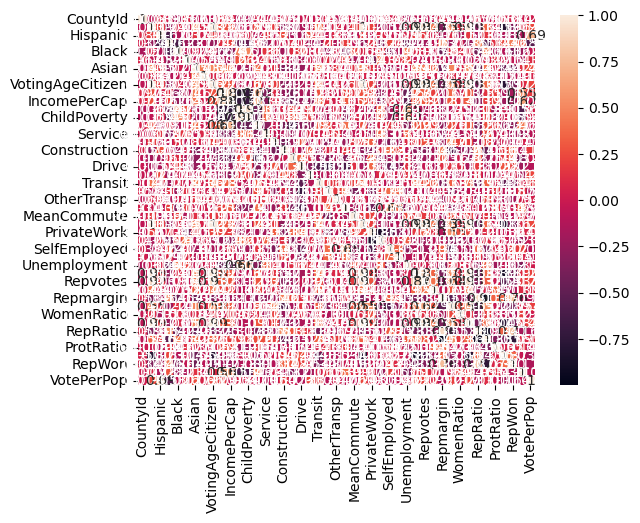

In [33]:
sb.heatmap(df.corr(), annot=True)
mp.show()

In [34]:
county_size_df = df[["TotalPop","VotingAgeCitizen","Log_Pop","Employed","RepRatio"]]
demography_df = df[["White","Hispanic","Black","Asian","Pacific","Native","WomenRatio","RepRatio"]]
wealth_df = df[["IncomePerCap","Income","Poverty","ChildPoverty","Unemployment","RepRatio"]]
labour1_df = df[["Professional","Service","Office","Construction","Production","RepRatio"]]
labour2_df = df[["PrivateWork","PublicWork","FamilyWork","SelfEmployed","RepRatio"]]
results_df = df[["Demvotes","Repvotes","Log_Pop","TotalPop","RepRatio","DemRatio","ProtRatio","AbsRepAdv","RepWon","VotePerCitizen"]]

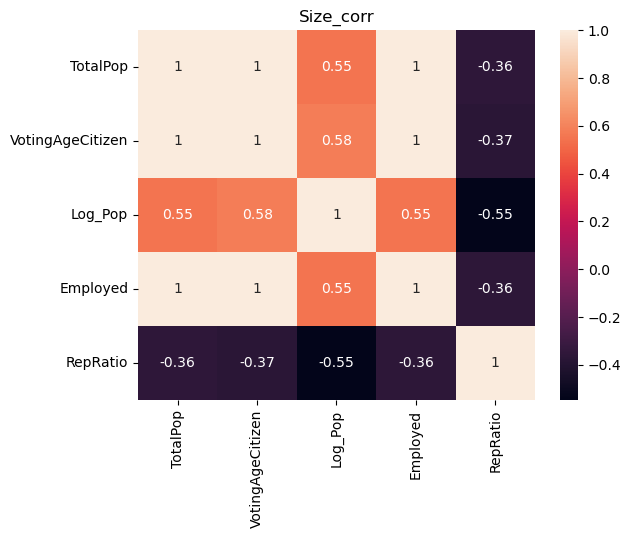

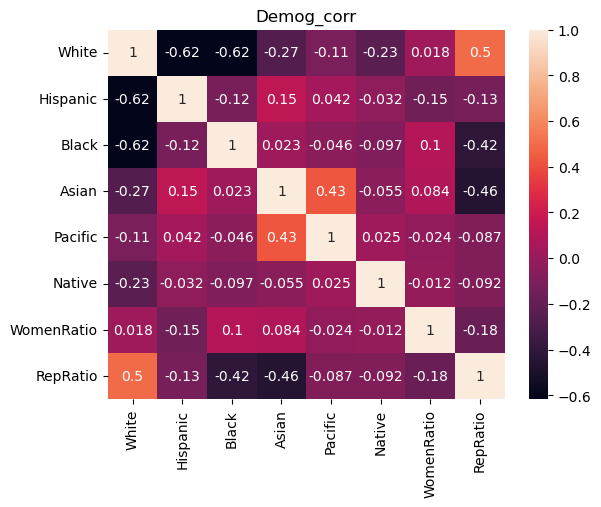

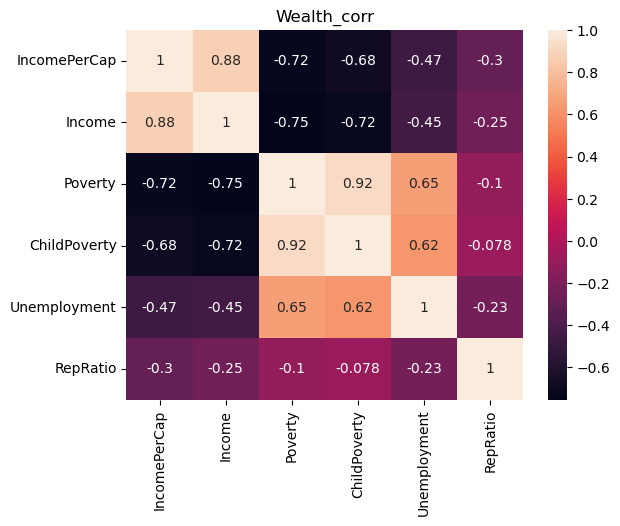

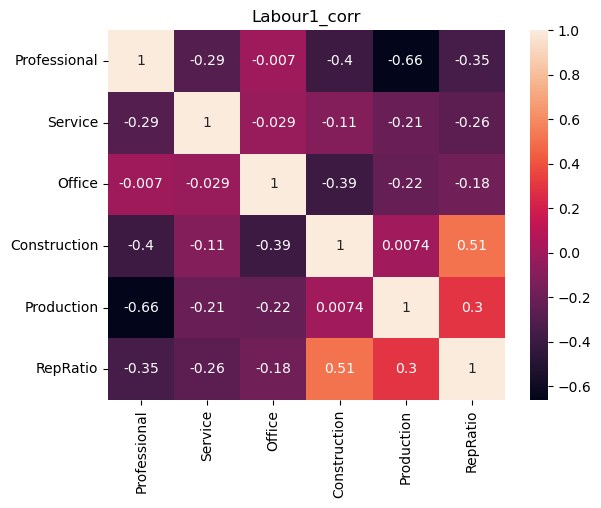

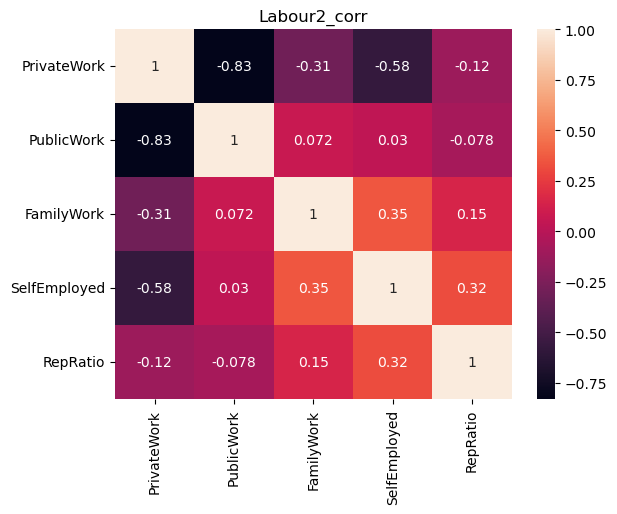

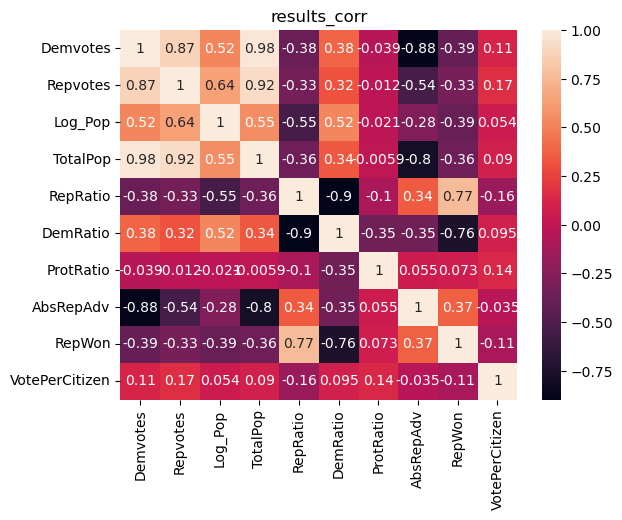

In [35]:

sb.heatmap(county_size_df.corr(), annot=True).set(title="Size_corr")
mp.show()
sb.heatmap(demography_df.corr(), annot=True).set(title="Demog_corr")
mp.show()
sb.heatmap(wealth_df.corr(), annot=True).set(title="Wealth_corr")
mp.show()
sb.heatmap(labour1_df.corr(), annot=True).set(title="Labour1_corr")
mp.show()
sb.heatmap(labour2_df.corr(), annot=True).set(title="Labour2_corr")
mp.show()
sb.heatmap(results_df.corr(), annot=True).set(title="results_corr")
mp.show()

In [36]:
lean_df = df[["Log_Pop",
             "White","Black","Asian","WomenRatio",
             "Poverty","Unemployment",
             "Professional","Construction",
             "PublicWork","SelfEmployed",
             "RepRatio","RepWon"]]

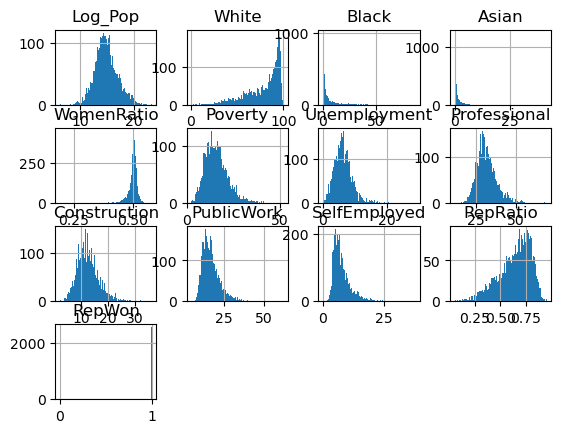

In [37]:
hist = lean_df.hist(bins=100)

[Text(0.5, 1.0, 'results_corr')]

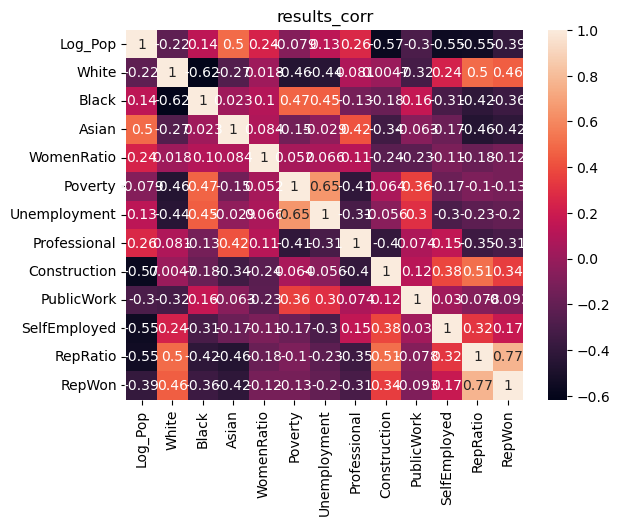

In [38]:
sb.heatmap(lean_df.corr(), annot=True).set(title="results_corr")

In [39]:
lean_df.to_csv("lean-data.csv")

### Part III: Random Forest, AdaBoost

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sb
import sklearn as sk
from sklearn import preprocessing as pp
from sklearn import tree
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.ensemble import RandomForestClassifier as rc
from sklearn.ensemble import AdaBoostClassifier as ab
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import GridSearchCV as gs

In [41]:
df = pd.read_csv("lean-data.csv")
df = df.drop(columns=["Unnamed: 0"])
df

,Log_Pop,White,Black,Asian,WomenRatio,Poverty,Unemployment,Professional,Construction,PublicWork,SelfEmployed,RepRatio,RepWon
0,15.748088,75.4,18.9,0.9,0.511247,13.7,5.2,35.3,8.1,20.2,5.6,0.716406,1
1,17.633676,83.1,9.5,0.7,0.510587,11.8,5.5,35.7,9.7,12.9,6.3,0.763999,1
2,14.677334,45.7,47.8,0.6,0.466585,27.2,12.4,25.0,11.5,19.1,6.5,0.535123,1
3,14.462758,74.6,22.0,0.0,0.457440,15.2,8.2,24.4,15.9,17.4,6.3,0.785081,1
4,15.815458,87.4,1.5,0.1,0.505957,15.6,4.9,28.5,15.8,11.9,4.0,0.896626,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,15.442393,79.6,0.8,0.6,0.483886,12.0,5.2,27.7,20.8,17.8,3.8,0.724896,1
3068,14.484508,81.5,0.5,2.2,0.469136,6.8,1.3,39.4,11.7,11.4,6.5,0.293549,0
3069,14.341380,87.7,0.1,0.1,0.489691,14.9,6.4,30.4,16.1,21.5,6.6,0.788223,1
3070,13.010703,82.2,0.3,0.1,0.501030,12.8,6.1,32.1,18.8,22.0,8.1,0.799655,1


In [42]:
data=pd.get_dummies(df, drop_first=True)
X=data.drop(columns=['RepRatio','RepWon'])
y=data['RepRatio']

In [43]:
#Keresztvalidáció lineáris regresszióra:
keresztval=cv(lm.LinearRegression(), X, y, cv=10, scoring='r2')
keresztval['test_score'].mean()

0.5395357052907278

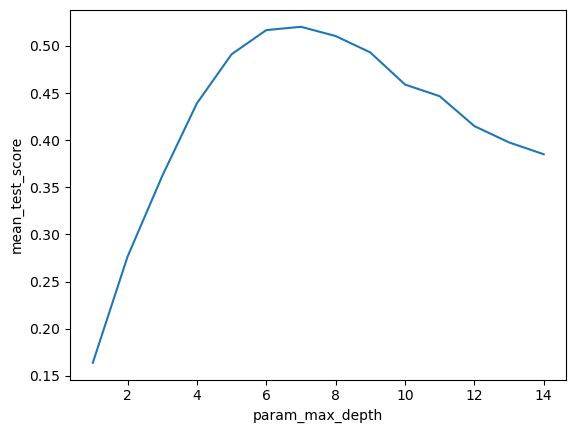

array([0.16383395, 0.27632285, 0.36192611, 0.43904157, 0.49112556,
       0.51676526, 0.52029613, 0.51047149, 0.49307974, 0.4590299 ,
       0.44663847, 0.41493673, 0.39763027, 0.38506836])

In [44]:
#Döntési fa hangolása:
racs={'max_depth': np.arange(start=1, stop=15, step=1)}
hang=gs(tree.DecisionTreeRegressor(), racs, scoring='r2', cv=10)
hang.fit(X, y)
eredmeny=hang.cv_results_
mp.cla()
sb.lineplot(x='param_max_depth', y='mean_test_score', data=eredmeny)
mp.show()
eredmeny['mean_test_score']

In [45]:
X=data.drop(columns=['RepRatio','RepWon'])
y=data['RepWon']
#Keresztvalidáció logisztikus regresszióra:
keresztval=cv(lm.LogisticRegression(), X, y, cv=10, scoring='r2')
keresztval['test_score'].mean()

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.3132796164075494

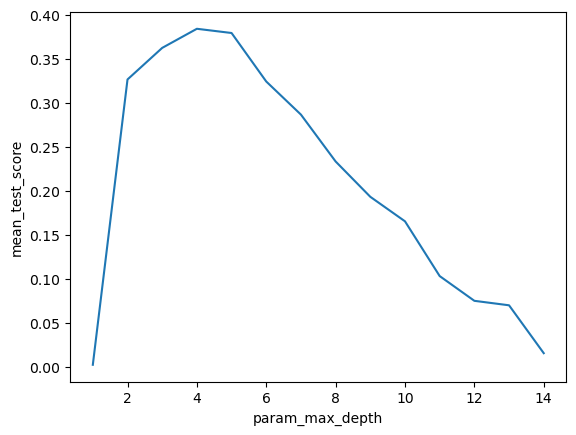

array([0.00220261, 0.32627148, 0.3621298 , 0.38383459, 0.37903948,
       0.3239458 , 0.28635059, 0.23311922, 0.19299485, 0.16514895,
       0.10295936, 0.07485242, 0.06976332, 0.01537986])

In [46]:
#Döntési fa hangolása:
racs={'max_depth': np.arange(start=1, stop=15, step=1)}
hang=gs(tree.DecisionTreeRegressor(), racs, scoring='r2', cv=10)
hang.fit(X, y)
eredmeny=hang.cv_results_
mp.cla()
sb.lineplot(x='param_max_depth', y='mean_test_score', data=eredmeny)
mp.show()
eredmeny['mean_test_score']

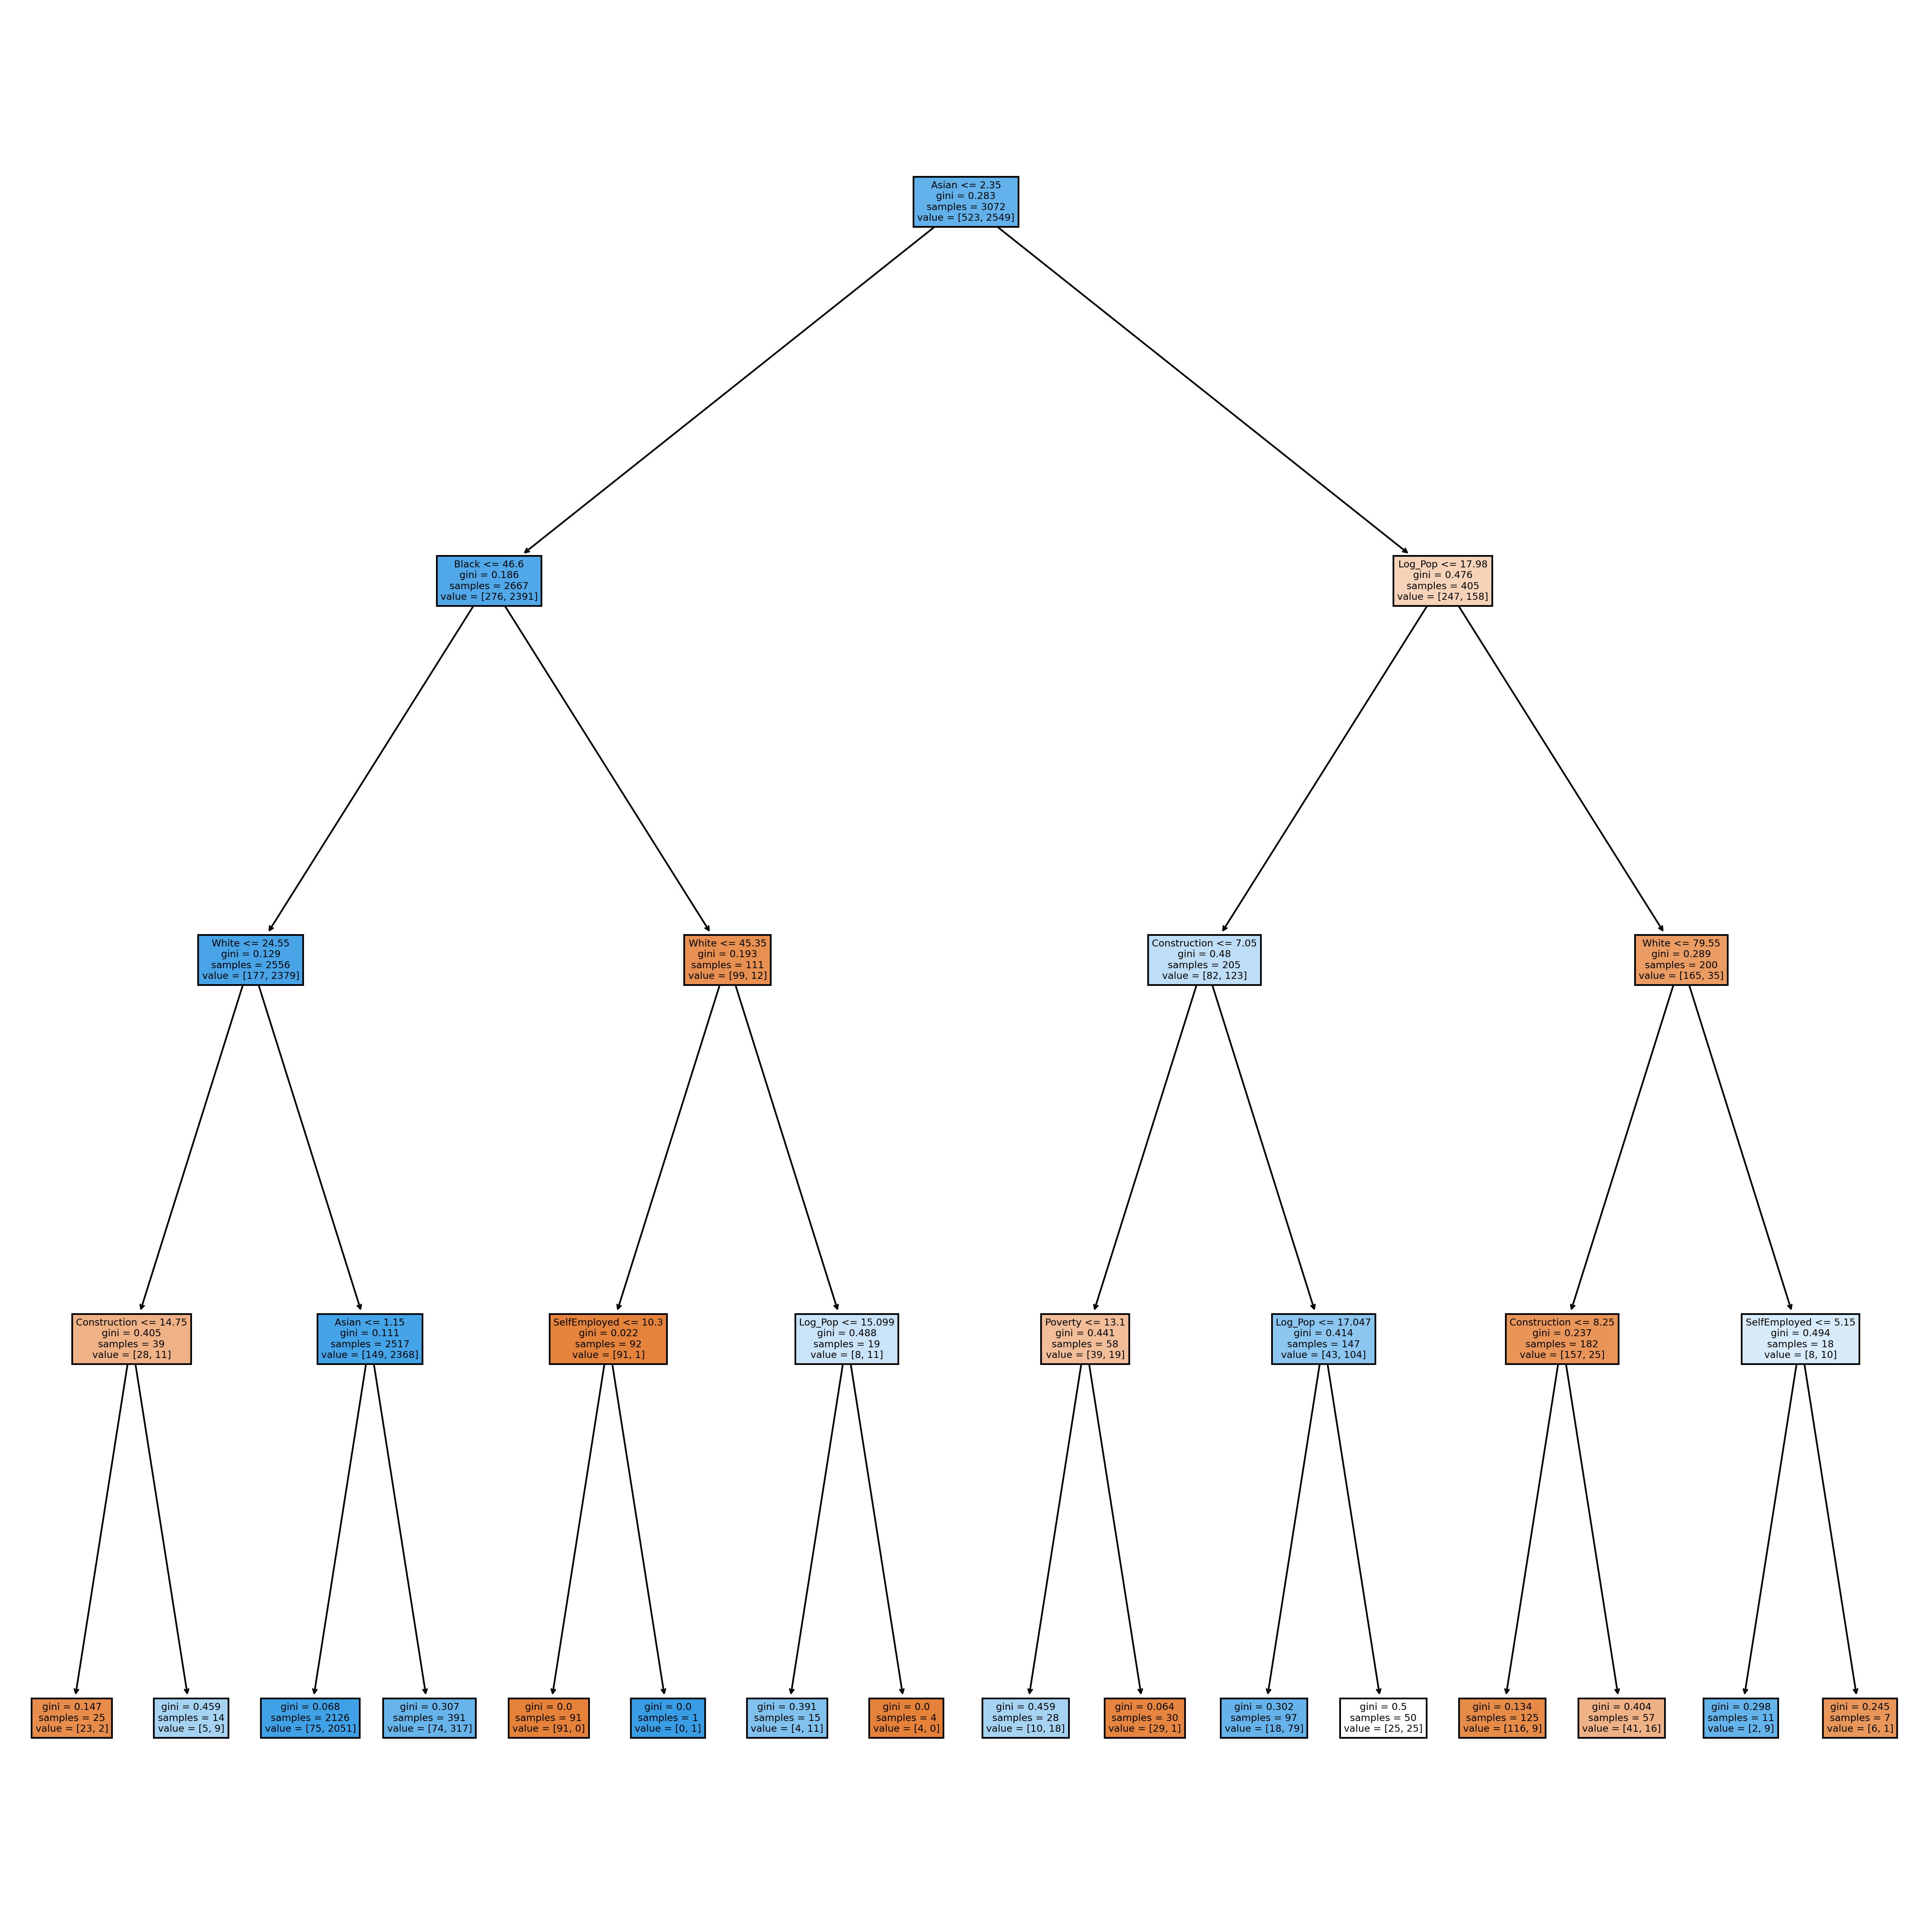

In [47]:
fa=tree.DecisionTreeClassifier(max_depth=4).fit(X,y)
mp.figure(figsize=(20,20),dpi=300)

mp.cla()
tree.plot_tree(fa, filled=True, feature_names=X.columns)
mp.show()

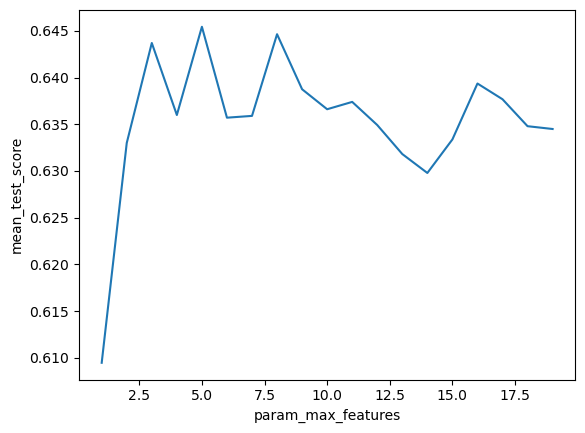

array([0.60945633, 0.63299897, 0.64370444, 0.6359915 , 0.64544031,
       0.63570538, 0.6358971 , 0.64464407, 0.63874981, 0.63660957,
       0.63739522, 0.63491742, 0.63180965, 0.62978378, 0.63337599,
       0.63936396, 0.63767965, 0.63479316, 0.63449403])

In [49]:
X=data.drop(columns=['RepRatio','RepWon'])
y=data['RepRatio']
#Véletlen erdő hangolása:
racs={'max_features': np.arange(start=1, stop=20, step=1)}
hang=gs(rf(n_estimators=30,max_depth=20), racs, scoring='r2', cv=10)
hang.fit(X, y)
eredmeny=hang.cv_results_
mp.cla()
sb.lineplot(x='param_max_features', y='mean_test_score', data=eredmeny)
mp.show()
eredmeny['mean_test_score']

### Part IV: Control for non-perfect data
##### IV.1.: Bootstrap

In [50]:
from matplotlib import pyplot as plt

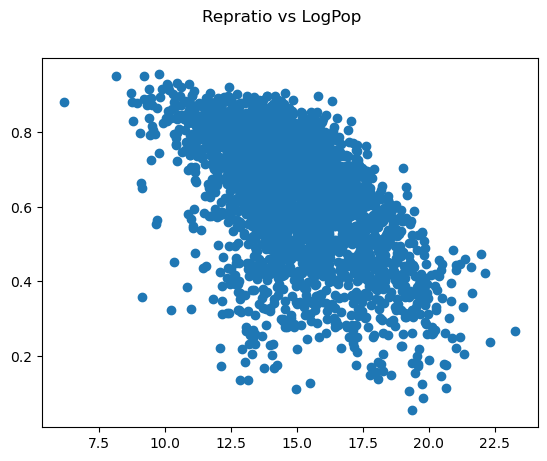

In [51]:
#Create a new mpyplot figure to plot into
fig = plt.figure()
 
#Set the title of the plot
fig.suptitle('Repratio vs LogPop')
 
#plot the time series and store the plot in the actual variable. We'll need that later for the legend.
actual = plt.scatter(df['Log_Pop'], df['RepRatio'])
 
#Show everything
plt.show()

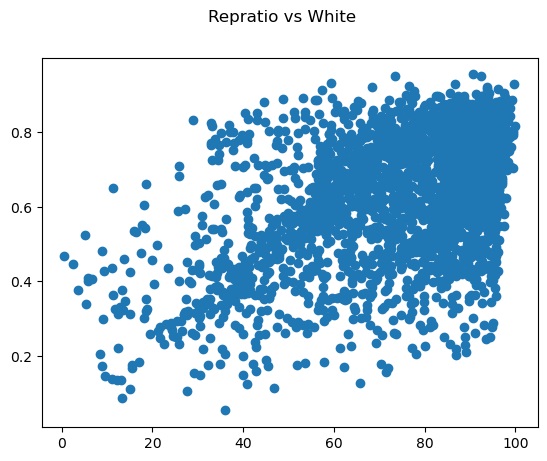

In [52]:
#Create a new mpyplot figure to plot into
fig = plt.figure()
 
#Set the title of the plot
fig.suptitle('Repratio vs White')
 
#plot the time series and store the plot in the actual variable. We'll need that later for the legend.
actual = plt.scatter(df['White'], df['RepRatio'])
 
#Show everything
plt.show()

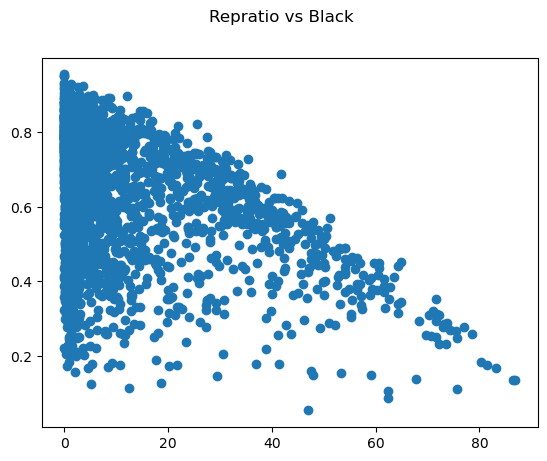

In [53]:
#Create a new mpyplot figure to plot into
fig = plt.figure()
 
#Set the title of the plot
fig.suptitle('Repratio vs Black')
 
#plot the time series and store the plot in the actual variable. We'll need that later for the legend.
actual = plt.scatter(df['Black'], df['RepRatio'])
 
#Show everything
plt.show()

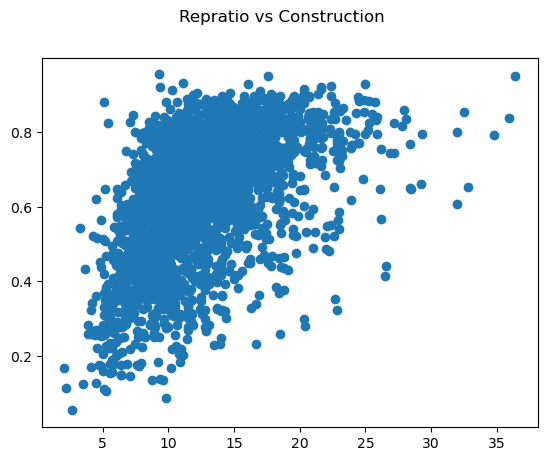

In [54]:
#Create a new mpyplot figure to plot into
fig = plt.figure()
 
#Set the title of the plot
fig.suptitle('Repratio vs Construction')
 
#plot the time series and store the plot in the actual variable. We'll need that later for the legend.
actual = plt.scatter(df['Construction'], df['RepRatio'])
 
#Show everything
plt.show()

In [55]:
from sklearn.linear_model import Ridge, Lasso
#https://notebook.community/DanielAndreasen/Programmers-Club/notebook/Regression%20-%20an%20example%20notebook

In [57]:
# Create the models
ridge_model = Ridge(fit_intercept=True, alpha=0.05)
lasso_model = Lasso(fit_intercept=True, alpha=0.05)
# Run the fit
res_ridge = ridge_model.fit(X, y)
res_lasso = lasso_model.fit(X, y)
# And predict the y-values & print the best-fit coefficients
y_pred_ridge = ridge_model.predict(X)
y_pred_lasso = lasso_model.predict(X)
print ("Ridge: a={0} b={1}\nLASSO: a={2} b={3}".format(res_ridge.intercept_, res_ridge.coef_[0],
                                                res_lasso.intercept_, res_lasso.coef_[0]))

Ridge: a=0.8805092206226309 b=-0.01634954035772051
LASSO: a=0.5180694705714612 b=-0.005697272864577585


#### Part V: ANN
I approach to use an ANN to predict the expected voterates. 

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sb
import sklearn as sk
from sklearn import preprocessing as pp
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, KFold
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [59]:
X=data.drop(columns=['RepRatio','RepWon'])
y=data['RepWon']
y=pd.get_dummies(y)
y=pd.DataFrame.to_numpy(y)
#0 és 1 közé transzformálás:
X=pp.MinMaxScaler().fit_transform(X)
X, Xtest, y, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 60        
                                                                 
 dense_1 (Dense)             (None, 2)                 12        
                                                                 
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
52/52 [==============================] - 2s 10ms/step - loss: 0.6691 - accuracy: 0.8196 - val_loss: 0.6500 - val_accuracy: 0.8180
Epoch 2/30
52/52 [==============================] - 0s 4ms/step - loss: 0.6196 - accuracy: 0.8384 - val_loss: 0.5994 - val_accuracy: 0.8180
Epoch 3/30
52/52 [==============================] - 0s 4ms/step - loss: 0.5631 - accuracy: 0.8378 - val_loss: 0.5481 - val_accuracy: 0.8180
Epoch 4/30
52/52 [=================

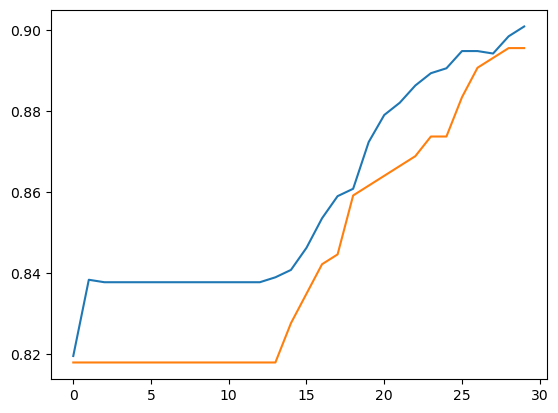

In [60]:
#Egyszerű ANN:
halo=Sequential()
halo.add(Dense(5, input_dim=11, activation='relu'))
halo.add(Dense(2, activation='softmax'))
halo.summary()
halo.compile(loss='binary_crossentropy',optimizer='adam', metrics='accuracy')
tanulas=halo.fit(X, y, epochs=30, validation_split=0.2)
mp.cla()
mp.plot(tanulas.history['accuracy'])
mp.plot(tanulas.history['val_accuracy'])
mp.show()

32/32 [==============================] - 0s 3ms/step


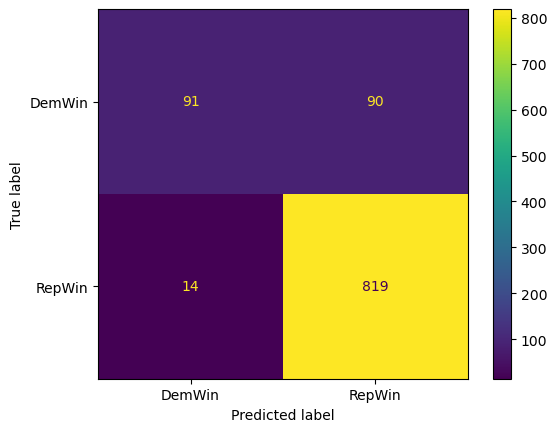

TypeError: 'numpy.float64' object is not callable

In [68]:
#Kiértékelés:
#Tévesztési mátrix:
halo_pred = halo.predict(Xtest)
halo_kat = np.round(halo_pred)
halo_kat = [row[1] for row in halo_kat]
y_valodi = [row[1] for row in ytest]
cm = confusion_matrix(y_valodi, halo_kat)
cm_abra = ConfusionMatrixDisplay(cm, display_labels=['DemWin', 'RepWin'])
cm_abra.plot()
mp.show()

#ROC görbe:
halo_val = [row[1] for row in halo_pred]
fpr, tpr, thresholds = roc_curve(y_valodi, halo_val)
auc = auc(fpr, tpr)
roc_abra = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
mp.cla()
roc_abra.plot()
mp.show()

In [62]:
#Keresztvalidáció:
keresztval = KFold(n_splits=5, shuffle=True)
acc=[]
for tanulo, val in keresztval.split(X,y):
    tanulas=halo.fit(X[tanulo], y[tanulo], epochs=20)
    scores=halo.evaluate(X[val], y[val], verbose=0)
    acc.append(scores[1]*100)
np.mean(acc)  

Epoch 1/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2736 - accuracy: 0.9040
Epoch 2/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2709 - accuracy: 0.9046
Epoch 3/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2687 - accuracy: 0.9028
Epoch 4/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2667 - accuracy: 0.9083
Epoch 5/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2644 - accuracy: 0.9058
Epoch 6/20
52/52 [==============================] - 0s 4ms/step - loss: 0.2634 - accuracy: 0.9058
Epoch 7/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2612 - accuracy: 0.9095
Epoch 8/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2596 - accuracy: 0.9046
Epoch 9/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2582 - accuracy: 0.9077
Epoch 10/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2569 - accuracy: 0.9095
Epoch 11/20
52/52 [

52/52 [==============================] - 0s 3ms/step - loss: 0.2512 - accuracy: 0.9059
Epoch 5/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2499 - accuracy: 0.9095
Epoch 6/20
52/52 [==============================] - 0s 2ms/step - loss: 0.2500 - accuracy: 0.9101
Epoch 7/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2506 - accuracy: 0.9053
Epoch 8/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2495 - accuracy: 0.9065
Epoch 9/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2502 - accuracy: 0.9101
Epoch 10/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2496 - accuracy: 0.9095
Epoch 11/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2501 - accuracy: 0.9089
Epoch 12/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2497 - accuracy: 0.9065
Epoch 13/20
52/52 [==============================] - 0s 3ms/step - loss: 0.2497 - accuracy: 0.9083
Epoch 14/20
52/52 [========

91.15713477134705

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 60        
                                                                 
 dense_3 (Dense)             (None, 5)                 30        
                                                                 
 dense_4 (Dense)             (None, 2)                 12        
                                                                 
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
52/52 [==============================] - 2s 10ms/step - loss: 0.5741 - accuracy: 0.8378 - val_loss: 0.5470 - val_accuracy: 0.8180
Epoch 2/30
52/52 [==============================] - 0s 5ms/step - loss: 0.5003 - accuracy: 0.8378 - val_loss: 0.4923 - val_accuracy: 0.8180
Epoch 3/30
52/52 [=====================

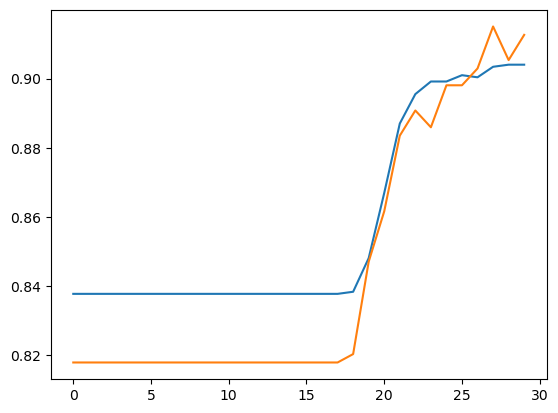

In [63]:
#Új ANN:
halo=Sequential()
halo.add(Dense(5, input_dim=11, activation='relu'))
halo.add(Dense(5, activation='relu'))
halo.add(Dense(2, activation='softmax'))
halo.summary()
halo.compile(loss='binary_crossentropy',optimizer='adam', metrics='accuracy')
tanulas=halo.fit(X, y, epochs=30, validation_split=0.2)
mp.plot(tanulas.history['accuracy'])
mp.plot(tanulas.history['val_accuracy'])
mp.show()

32/32 [==============================] - 0s 3ms/step


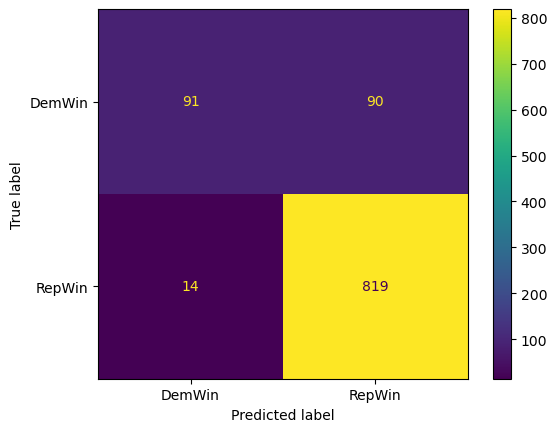

In [66]:
#Kiértékelés:
#Tévesztési mátrix:
halo_pred = halo.predict(Xtest)
halo_kat = np.round(halo_pred)
halo_kat = [row[1] for row in halo_kat]
y_valodi = [row[1] for row in ytest]
cm = confusion_matrix(y_valodi, halo_kat)
cm_abra = ConfusionMatrixDisplay(cm, display_labels=['DemWin', 'RepWin'])
cm_abra.plot()
mp.show()

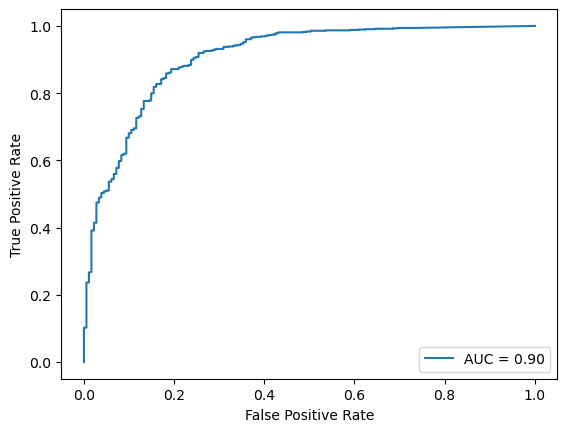

In [65]:
#ROC görbe:
halo_val = [row[1] for row in halo_pred]
fpr, tpr, thresholds = roc_curve(y_valodi, halo_val)
roc_abra = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
roc_abra.plot()
mp.show()